<a href="https://colab.research.google.com/github/CMDRZero/DataScienceFundamentalsClass/blob/main/GranBellU4Proj_atmp_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install preliz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 9.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [2]:
import arviz as az
import pymc as pm     #The engine of prediction
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import preliz as pz   #We are using this so I can make the nice graphs of priors and likelyhoods
import urllib.request

In [88]:
url = 'https://raw.githubusercontent.com/CMDRZero/DataScienceFundamentalsClass/main/countryage.txt'
data = eval(urllib.request.urlopen(url).read())

In [107]:
common = []
pairs = [(key, data[key]) for key in data]
spairs = sorted(pairs, key=lambda x: len(x[1]), reverse = True)
keys = [k for k,d in spairs[:30]]
for cat in keys:
  dat = data[cat]
  np.random.shuffle(dat)
  for v in dat[:1000]:
    if v != '':
      common.append((int(v)+1, cat))

In [108]:
frame = pd.DataFrame(common)
frame

,0,1
0,72,
1,39,
2,33,
3,94,
4,75,
...,...,...
29995,86,Austria-Hungary
29996,7,Austria-Hungary
29997,90,Austria-Hungary
29998,86,Austria-Hungary


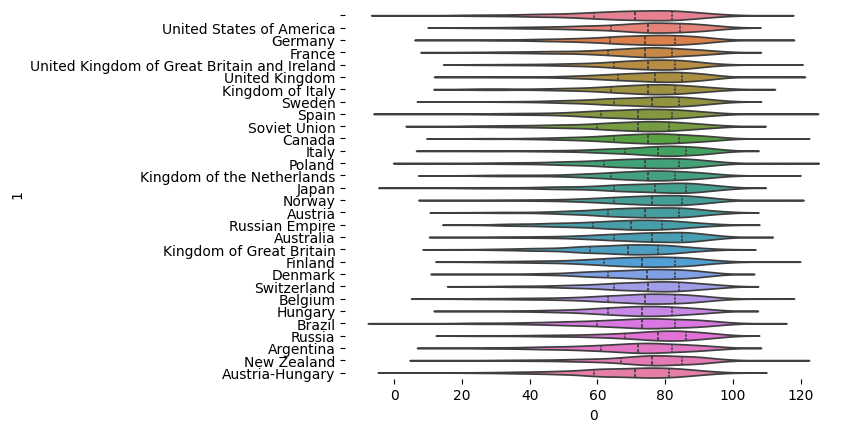

In [109]:
#visualize theoretical chem shift values for all the amino acids
sns.violinplot(frame, x=0, y=1, inner='quart',hue=1)
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

In [110]:
encode = pd.Categorical(frame[1])
idx = encode.codes
coords = {'cc': encode.categories}

In [111]:
#Define our model using the python `with` syntax
with pm.Model(coords = coords) as nh_model:
  k = pm.Normal('k', mu = 70, sigma = 20, dims = 'cc') #Using values derived above
  l = pm.Gamma('l', 3, .4, dims = 'cc')  #Using values from above

  y = pm.Weibull('y', alpha = l[idx], beta = k[idx], observed = frame[0])

  samples = pm.sample()

Output()

Output()

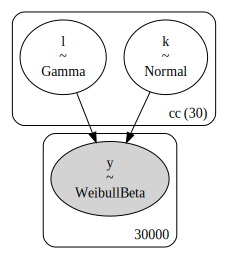

In [112]:
pm.model_to_graphviz(nh_model)

In [113]:
pm.sample_posterior_predictive(samples, model=nh_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

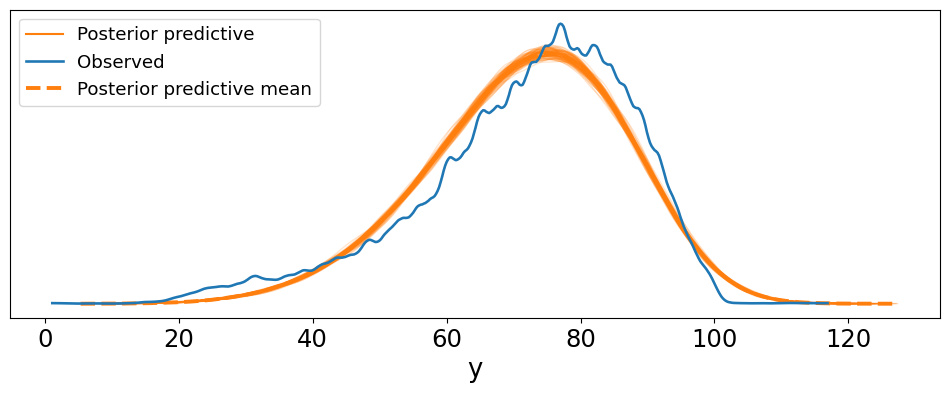

In [114]:
az.plot_ppc(samples, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
#plt.xlim([-10,10]) #:O thx chatgpt ("Is it possible to limit the range displayed on a python avriz ppc graph")

array([[<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'l'}>, <Axes: title={'center': 'l'}>]],
      dtype=object)

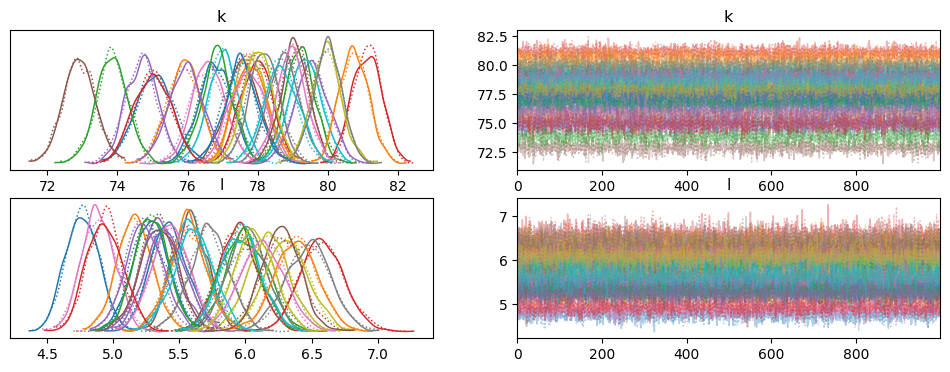

In [115]:
az.plot_trace(samples)

In [116]:
az.rhat(samples).to_dataarray().to_numpy()

array([[0.99981242, 1.00103593, 1.00581334, 1.00087364, 1.00054684,
        0.99968892, 1.00466982, 1.00152266, 0.99965075, 0.99969372,
        1.00073281, 1.0010633 , 1.00044953, 1.00059149, 1.00130379,
        1.00061135, 1.00513286, 1.00122279, 1.00364507, 1.00069556,
        1.00088723, 1.00067139, 0.99967753, 1.00094173, 0.99975527,
        1.0008148 , 1.00202342, 0.99943401, 0.99943195, 1.00271477],
       [1.00037642, 0.99948515, 1.00228521, 1.00205074, 1.00026382,
        1.00072328, 0.99984422, 1.00818794, 1.00001196, 0.99992044,
        1.00416232, 1.00190216, 1.00099509, 0.99994268, 1.0005981 ,
        1.00148271, 0.9999414 , 1.00044862, 1.00012304, 1.00297976,
        1.00098141, 1.00002415, 1.00034063, 1.00192819, 1.00080111,
        1.00194899, 1.0013587 , 0.99943246, 1.00033458, 0.99971455]])

In [117]:
az.rhat(samples).data_vars

Data variables:
    k        (cc) float64 240B 0.9998 1.001 1.006 1.001 ... 0.9994 0.9994 1.003
    l        (cc) float64 240B 1.0 0.9995 1.002 1.002 ... 0.9994 1.0 0.9997

In [118]:
coords[list(az.rhat(samples).coords)[0]]

Index(['', 'Argentina', 'Australia', 'Austria', 'Austria-Hungary', 'Belgium',
       'Brazil', 'Canada', 'Denmark', 'Finland', 'France', 'Germany',
       'Hungary', 'Italy', 'Japan', 'Kingdom of Great Britain',
       'Kingdom of Italy', 'Kingdom of the Netherlands', 'New Zealand',
       'Norway', 'Poland', 'Russia', 'Russian Empire', 'Soviet Union', 'Spain',
       'Sweden', 'Switzerland', 'United Kingdom',
       'United Kingdom of Great Britain and Ireland',
       'United States of America'],
      dtype='object')

array([<Axes: >], dtype=object)

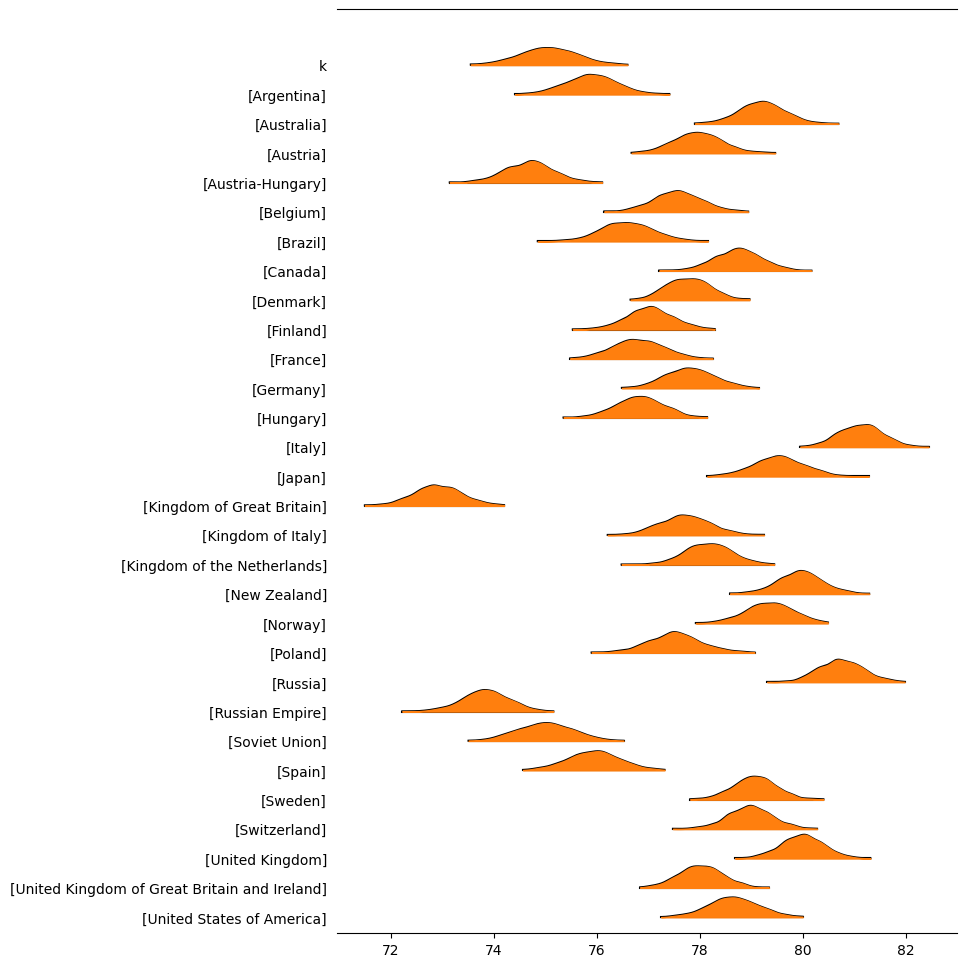

In [119]:
az.plot_forest(samples, var_names=['k'], kind='ridgeplot', hdi_prob = .9987, combined=True, colors=["C1", "C0", "C1"], figsize=(8, 12))

array([<Axes: >], dtype=object)

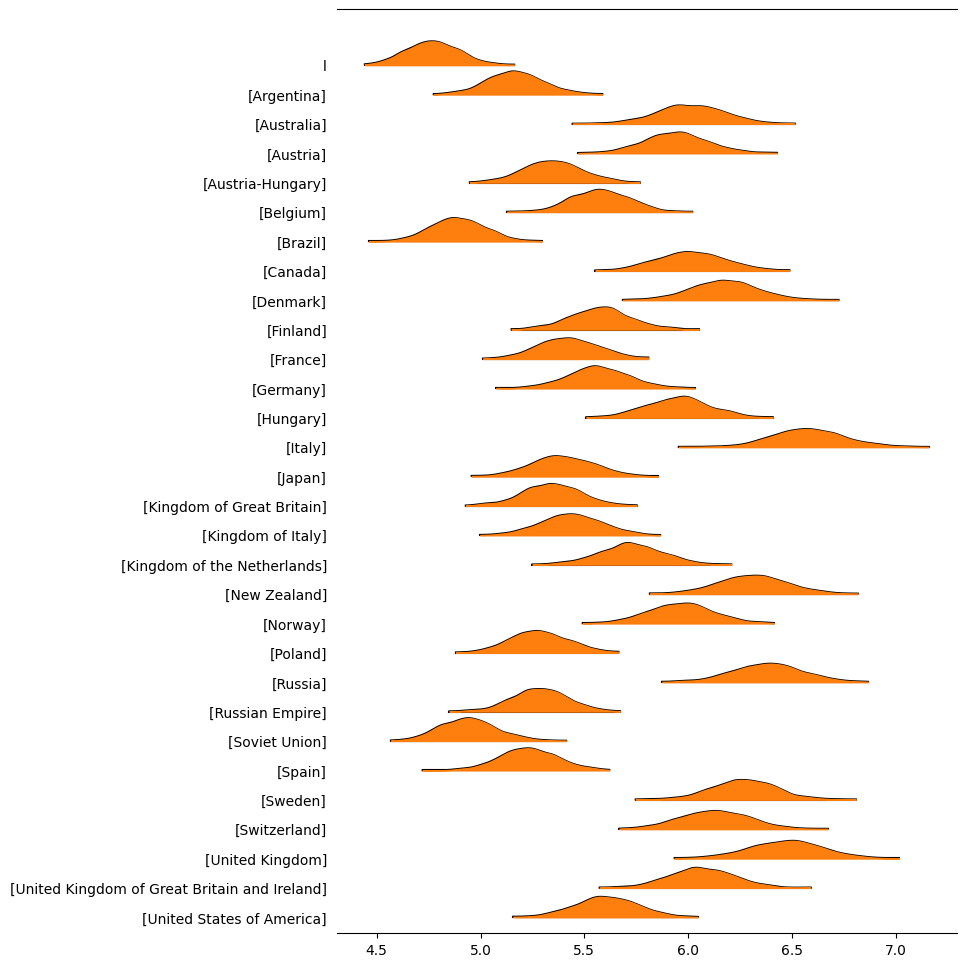

In [120]:
az.plot_forest(samples, var_names=['l'], kind='ridgeplot', hdi_prob = .9987, combined=True, colors=["C1", "C0", "C1"], figsize=(8, 12))

In [122]:
common = []
pairs = [(key, data[key]) for key in data]
spairs = sorted(pairs, key=lambda x: len(x[1]), reverse = True)
keys = [k for k,d in spairs[:15]]
for cat in keys:
  dat = data[cat]
  np.random.shuffle(dat)
  for v in dat[:500]:
    if v != '':
      common.append((int(v)+1, cat))

In [123]:
frame = pd.DataFrame(common)

In [124]:
encode = pd.Categorical(frame[1])
idx = encode.codes
coords = {'cc': encode.categories}

In [135]:
#Define our model using the python `with` syntax
with pm.Model(coords = coords) as nh_hp_model:
  k_mu = pm.Normal('k_mu', mu = 70, sigma = 20, dims = 'cc')
  k_sigma = pm.HalfNormal('k_sigma', sigma = 20, dims = 'cc')

  l_alpha = pm.Normal('l_alpha', mu = 3, sigma = .4, dims = 'cc')
  l_beta = pm.HalfNormal('l_beta', sigma = .4, dims = 'cc')

  k = pm.Normal('k', mu = k_mu, sigma = k_sigma, dims = 'cc')
  l = pm.Gamma('l', l_alpha, l_beta, dims = 'cc')

  y = pm.Weibull('y', alpha = l[idx], beta = k[idx], observed = frame[0])

  hp_samples = pm.sample(target_accept=.95)

Output()

Output()

ValueError: Not enough samples to build a trace.

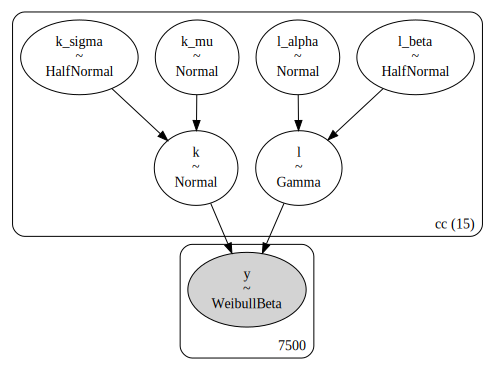

In [126]:
pm.model_to_graphviz(nh_hp_model)

<Axes: xlabel='y'>

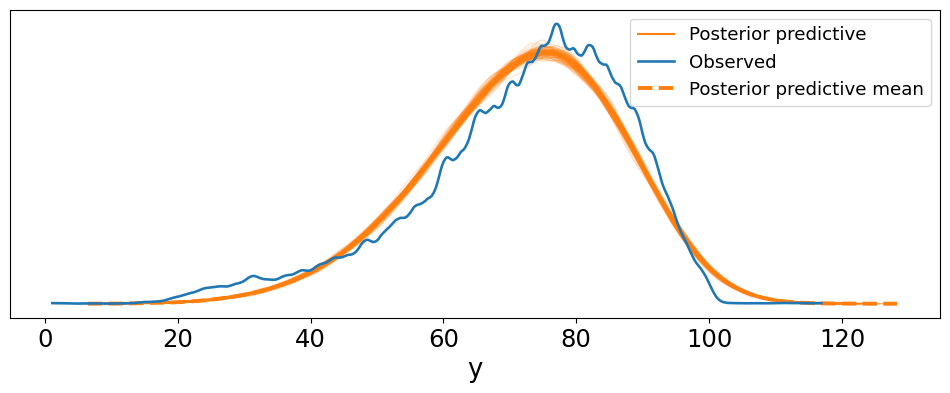

In [127]:
az.plot_ppc(samples, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

array([[<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'l'}>, <Axes: title={'center': 'l'}>]],
      dtype=object)

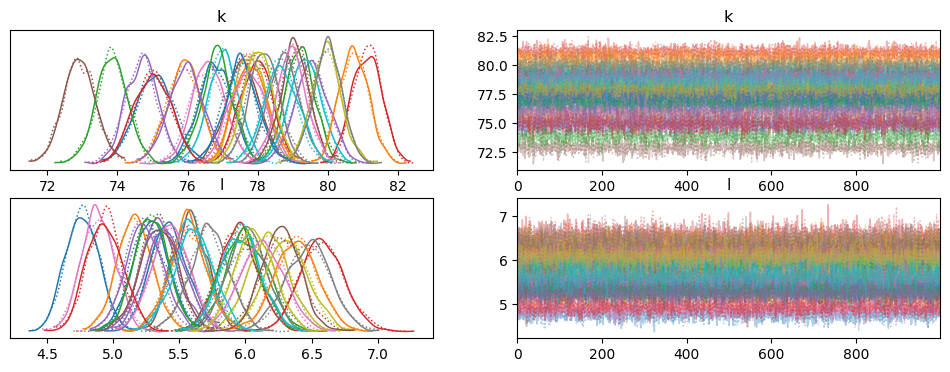

In [128]:
az.plot_trace(samples)

In [129]:
az.rhat(samples).to_dataarray().to_numpy()

array([[0.99981242, 1.00103593, 1.00581334, 1.00087364, 1.00054684,
        0.99968892, 1.00466982, 1.00152266, 0.99965075, 0.99969372,
        1.00073281, 1.0010633 , 1.00044953, 1.00059149, 1.00130379,
        1.00061135, 1.00513286, 1.00122279, 1.00364507, 1.00069556,
        1.00088723, 1.00067139, 0.99967753, 1.00094173, 0.99975527,
        1.0008148 , 1.00202342, 0.99943401, 0.99943195, 1.00271477],
       [1.00037642, 0.99948515, 1.00228521, 1.00205074, 1.00026382,
        1.00072328, 0.99984422, 1.00818794, 1.00001196, 0.99992044,
        1.00416232, 1.00190216, 1.00099509, 0.99994268, 1.0005981 ,
        1.00148271, 0.9999414 , 1.00044862, 1.00012304, 1.00297976,
        1.00098141, 1.00002415, 1.00034063, 1.00192819, 1.00080111,
        1.00194899, 1.0013587 , 0.99943246, 1.00033458, 0.99971455]])

In [130]:
coords[list(az.rhat(samples).coords)[0]][2]

'France'

array([<Axes: >], dtype=object)

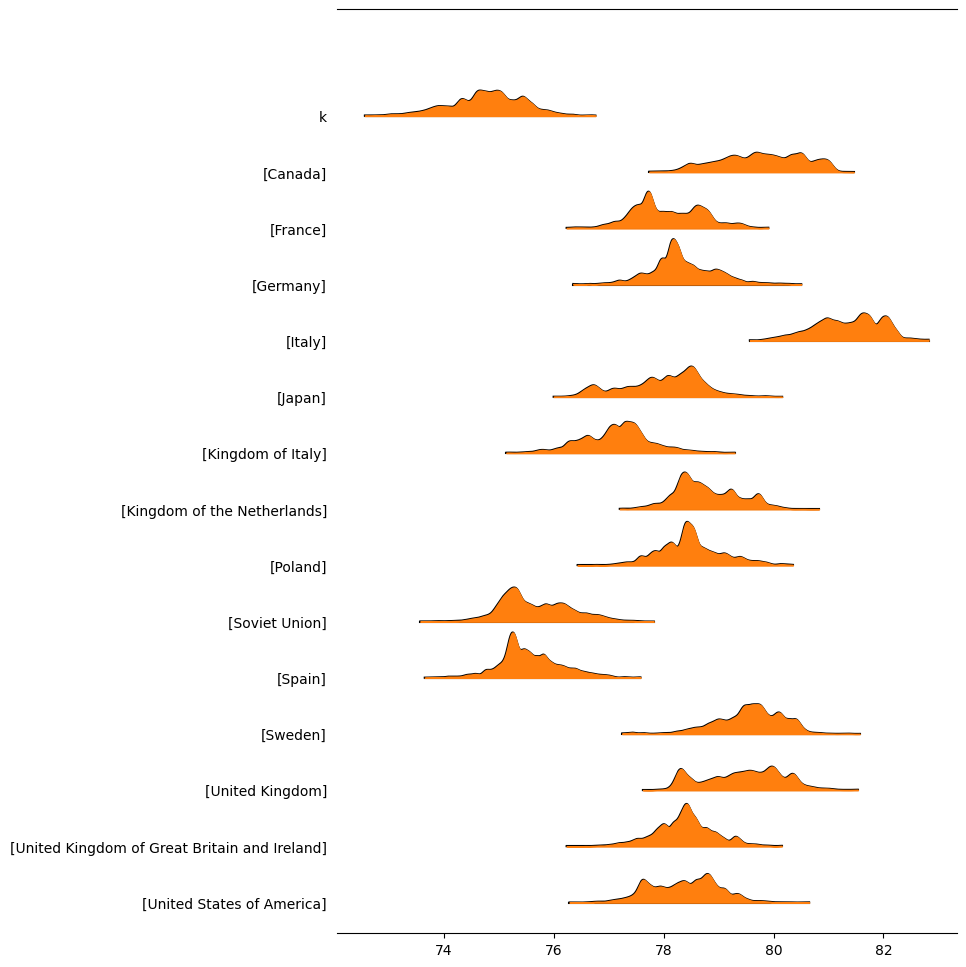

In [131]:
az.plot_forest(hp_samples, var_names=['k'], kind='ridgeplot', hdi_prob = .9987, combined=True, colors=["C1", "C0", "C1"], figsize=(8, 12))

array([<Axes: >], dtype=object)

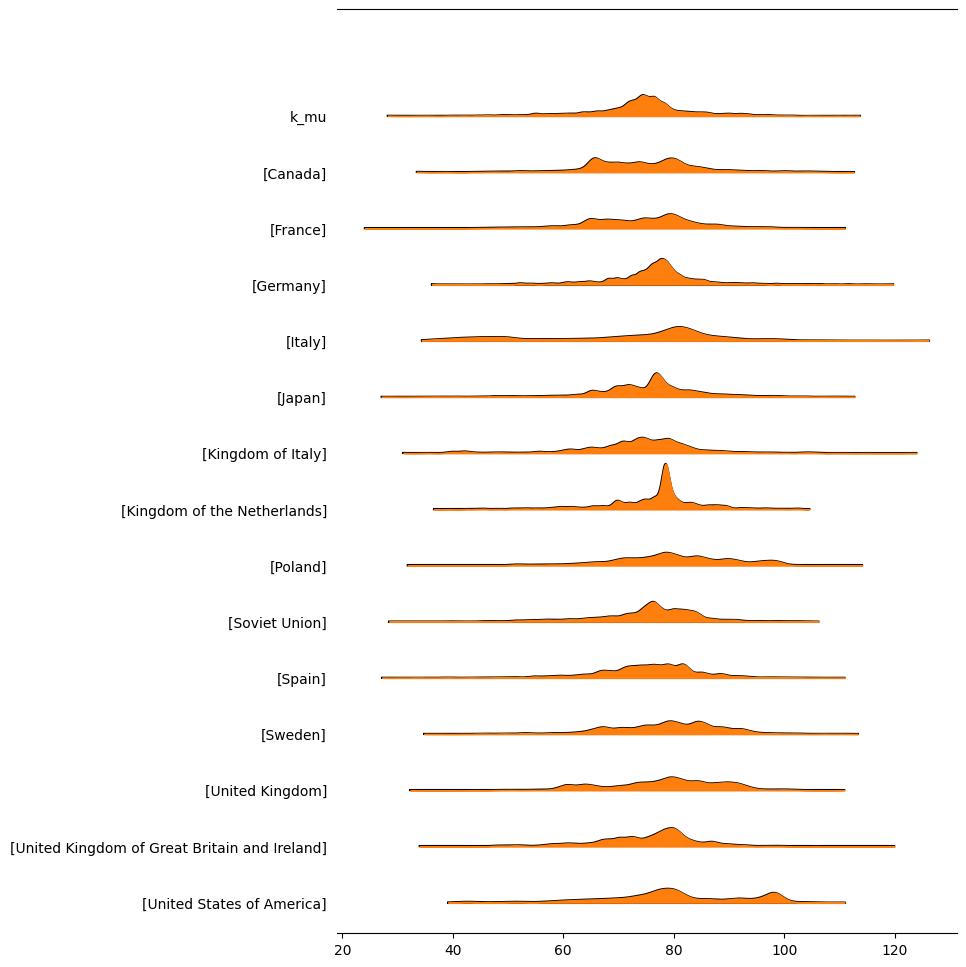

In [134]:
az.plot_forest(hp_samples, var_names=['k_mu'], kind='ridgeplot', hdi_prob = .9987, combined=True, colors=["C1", "C0", "C1"], figsize=(8, 12))